In [245]:
import numpy as np
import pickle
import torch
import random
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import defaultdict

from IPython.display import clear_output

%matplotlib inline

In [246]:
NUM_READ_FEATURES = 11  #size of each read's feature vector from M2 annotation
NUM_INFO_FEATURES = 9   # size of each variant's info field tensor (3 components for HEC, one each for HAPDOM, HAPCOMP)
                        # and 5 for ref bases STR info
REF_DOWNSAMPLE = 10 # choose this many ref reads randomly
MIN_REF = 5
ARTIFACT_POPAF_THRESHOLD = 5.9 # only let things absent from gnomAD be artifacts out of caution
GERMLINE_POPAF_THRESHOLD = 1 #also very cautious.  There are so many germline variants we can be wasteful!
TLOD_THRESHOLD = 6 # we are classified artifacts other than sequencing errors described by base qualities
NON_ARTIFACT_PER_ARTIFACT = 50 #ratio of non-artifact to artifact in unsupervised training data

BATCH_SIZE = 64

In [247]:
#as a quick and robust estimate of the mean for the purpose of normalizing, we will take the median of medians of subsets
#for example, take the median of each group of 100 read sets, then take the median of those
NUM_SETS_PER_MEAN = 100

def find_normalization(data):
    medians = []
    spreads = []
    buffer = []
    for n, (ref_tensor, _, _) in enumerate(data):
        buffer.append(ref_tensor)
        
        if n > 0 and n % NUM_SETS_PER_MEAN == 0:
            medians.append(torch.quantile(torch.cat(buffer, dim=0), 0.5, dim=0))
            low_quantile = torch.quantile(torch.cat(buffer, dim=0), 0.02, dim=0)
            high_quantile = torch.quantile(torch.cat(buffer, dim=0), 0.98, dim=0)
            spreads.append(high_quantile - low_quantile)
            buffer.clear()
    mu = torch.median(torch.stack(medians), dim=0).values
    sigma = torch.median(torch.stack(spreads), dim=0).values
    
    return mu, sigma

def normalize(data, mu, sigma):
    return [((ref - mu) / sigma, (alt - mu) / sigma, is_artifact) for ref, alt, is_artifact in data]

In [248]:
    def num_repeats(ref_bases, k):
        N = len(ref_bases)
        n = int((N - 1)/2)   # note k > n will cause errors
        
        # extend a repeat forward, to front and then to back (both exclusive)
        # note that this only extends backward if they match the bases going forward
        # that is AAAAAGTGTCC (first G in the middle) will get extended forward through
        # both GTs but won't be extended back
        front = n + k
        while front < N and ref_bases[front] == ref_bases[front - k]:
            front = front + 1
        back = n - 1
        while back >= 0 and ref_bases[back] == ref_bases[back + k]:
            back = back - 1    
        forward_repeats = (front - back - 1)/k
        
        # same idea but extending backwards first (now back is exclusive and front is inclusive)
        back = n - k
        while back >= 0 and ref_bases[back] == ref_bases[back + k]:
            back = back - 1
        front = n + 1
        while front < N and ref_bases[front] == ref_bases[front - k]:
            front = front + 1  
        backward_repeats = (front - back - 1)/k
           
        return forward_repeats, backward_repeats

In [249]:
class SiteMetadata:
    def __init__(self, chromosome, position, ref, alt, popaf):
        self._locus = chromosome + ":" + str(position)
        self._ref = ref
        self._alt = alt
        self._popaf = popaf
        
    def locus(self):
        return self._locus
    
    def ref(self):
        return self._ref
    
    def alt(self):
        return self._alt
    
    def popaf(self):
        return self._popaf
    
class Mutect2Data:
    def __init__(self, tlod, tumor_dp, filters):
        self._tlod = tlod
        self._tumor_dp = tumor_dp
        self._filters = filters
        
    def tlod(self):
        return self._tlod
    
    def tumor_depth(self):
        return self._tumor_dp
    
    def filters(self):
        return self._filters
    
class VariantInfoFeatures:
    #hec is abbreviation for haplotype equivalence counts
    def __init__(self, hec, haplotype_complexity, haplotype_dominance, ref_bases):
        # take integer haplotype equivalence counts (already in order from greatest to least from Mutect)
        # and calculate the fractional share of the 2nd and 3rd, or 0 if none exist
        total = 0
        for n in hec:
            total += n
            
        self._info = [0.0 if len(hec) < 2 else hec[1]/total, 0.0 if len(hec) < 3 else hec[2]/total]
        
        # now append the haplotype complexity and haplotype dominance
        self._info.append(haplotype_complexity)
        self._info.append(haplotype_dominance)
        
        #TODO: process ref bases into a feature vector and append
        
        # ref bases is symmetrical and has 2n+1 bases, with the middle one being the site in question
        for k in range(1,6):
            fwd,back = num_repeats(ref_bases, k)
            self._info.append(max(fwd,back))
        
        self._info = torch.FloatTensor(self._info)
        
    def get_info_tensor(self):
        return self._info
    
    # count how many repeats of length k surround the middle base
    # example: num_repeats(GACTACTACTG,3) = 3
    def num_repeats(ref_bases, k):
        N = len(ref_bases)
        n = int((N - 1)/2)   # note k > n will cause errors
        
        # extend a repeat forward, to front and then to back (both exclusive)
        # note that this only extends backward if they match the bases going forward
        # that is AAAAAGTGTCC (first G in the middle) will get extended forward through
        # both GTs but won't be extended back
        front = n + k
        while front < N and ref_bases[front] == ref_bases[front - k]:
            front = front + 1
        back = n - 1
        while back >= 0 and ref_bases[back] == ref_bases[back + k]:
            back = back - 1    
        forward_repeats = (front - back - 1)/k
        
        # same idea but extending backwards first (now back is exclusive and front is inclusive)
        back = n - k
        while back >= 0 and ref_bases[back] == ref_bases[back + k]:
            back = back - 1
        front = n + 1
        while front < N and ref_bases[front] == ref_bases[front - k]:
            front = front + 1  
        backward_repeats = (front - back - 1)/k
           
        return max(forward_repeats, backward_repeats)

In [250]:
class Datum:
    def __init__(self, ref_tensor, alt_tensor, info_tensor, metadata, mutect2_data, artifact_label):
        self._ref_tensor = ref_tensor
        self._alt_tensor = alt_tensor
        self._info_tensor = info_tensor
        self._metadata = metadata
        self._mutect2_data = mutect2_data
        self._artifact_label = artifact_label
        
    def ref_tensor(self):
        return self._ref_tensor
    
    def alt_tensor(self):
        return self._alt_tensor
    
    def info_tensor(self):
        return self._info_tensor
    
    def metadata(self):
        return self._metadata
    
    def mutect2_data(self):
        return self._mutect2_data
    
    def artifact_label(self):
        return self._artifact_label

In [251]:
def index_if_exists(lis, element):
    return lis.index(element) if element in lis else None

def get_indices(lis, elements):
    return tuple(index_if_exists(lis, element) for element in elements)

ALLELE_SEPARATOR = '|'
# get the ref and alt tensors from the VariantsToTable raw output, convert to torch tensors, downsample ref if needed
def get_read_tensors(token, ref_downsample=None):
    tokens = token.split(ALLELE_SEPARATOR)
    ref, alt = tuple(np.fromstring(x, dtype=int, sep=',').reshape((-1, NUM_READ_FEATURES)) for x in tokens)
    ref, alt = torch.from_numpy(ref).float(), torch.from_numpy(alt).float()
    if (ref_downsample is not None and len(ref) > ref_downsample):
        ref = ref[torch.randperm(len(ref))[:ref_downsample]]
    return ref, alt

class TableReader:
    def __init__(self, header_tokens, tumor_sample, normal_sample=None):
        
        # site metadata
        self.chrom_idx, self.pos_idx, self.ref_allele_idx, self.alt_allele_idx, self.popaf_idx = \
            get_indices(header_tokens, ["CHROM", "POS", "REF", "ALT", "POPAF"])
        
        # Mutect2 data
        self.filter_idx, self.tlod_idx, self.tumor_dp_idx,  = \
            get_indices(header_tokens, ["FILTER", "TLOD", tumor_sample + ".DP"])
        
        # variant info features
        self.hec_idx, self.hapcomp_idx, self.hapdom_idx, self.ref_bases_idx = get_indices(header_tokens, ["HEC", "HAPCOMP", "HAPDOM", "REF_BASES"])
        
        self.status_idx = index_if_exists(header_tokens, "STATUS")
        self.tumor_idx = index_if_exists(header_tokens, tumor_sample + ".FRS")
        
        # optional normal data
        if normal_sample is not None:
            self.normal_idx, self.normal_dp_idx = get_indices(header_tokens, [normal_sample + ".FRS", normal_sample + ".DP"])
    
    def variant_info_features(self, tokens):
        haplotype_equivalence_counts = [int(n) for n in tokens[self.hec_idx].split(",")]
        haplotype_complexity = int(tokens[self.hapcomp_idx])
        haplotype_dominance = float(tokens[self.hapdom_idx])
        ref_bases = tokens[self.ref_bases_idx]
        return VariantInfoFeatures(haplotype_equivalence_counts, haplotype_complexity, haplotype_dominance, ref_bases)
        
    def site_metadata(self, tokens):
        chromosome = tokens[self.chrom_idx]
        position = int(tokens[self.pos_idx])
        ref = tokens[self.ref_allele_idx]
        alt = tokens[self.alt_allele_idx]
        popaf = float(tokens[self.popaf_idx]) 
        return SiteMetadata(chromosome, position, ref, alt, popaf)
    
    def mutect2_data(self, tokens):
        tlod = float(tokens[self.tlod_idx])
        tumor_dp = int(tokens[self.tumor_dp_idx])
        filters = set(tokens[self.filter_idx].split(","))
        return Mutect2Data(tlod, tumor_dp, filters)

    def status(self, tokens):
        return tokens[self.status_idx]
    
    def tumor_ref_and_alt(self, tokens, ref_downsample=None):
        return get_read_tensors(tokens[self.tumor_idx], ref_downsample)
    
    def normal_dp(self, tokens):
        return int(tokens[self.normal_dp_idx])
    
    def normal_ref_and_alt(self, tokens, ref_downsample=None):
        return get_read_tensors(tokens[self.normal_idx], ref_downsample)

In [347]:
# this takes a table from VariantsToTable and produces a list of either
# (ref tensor, alt tensor, and unsupervised label based on AF) if is_training = true
# (ref tensor, alt tensor, (position, filters, status)) if is_training = false
def make_tensors(raw_file, is_training, sample_name, normal_sample_name=None):
    data = []
            
    # simple online method for balanced data set where for each k-alt-read artifact there are 
    # NON_ARTIFACT_PER_ARTIFACT (downsampled) k-alt-read non-artifacts.  That is, alt count is not an informative feature.
    unmatched_artifact_counts = []
        
    with open(raw_file) as fp: 
        reader = TableReader(fp.readline().split(), sample_name, normal_sample_name)
        
        for n, line in enumerate(fp):
            if n % 100000 == 0:
                print("Processing line " + str(n))
                
            tokens = line.split()
            metadata = reader.site_metadata(tokens)
            m2_data = reader.mutect2_data(tokens)

            # Contamination and weak evidence / low log odds have low AFs but are not artifacts.  We exclude them
            # from training.  As for testing, M3 will continue to rely on them 
            if "contamination" in m2_data.filters() or "weak_evidence" in m2_data.filters() or m2_data.tlod() < TLOD_THRESHOLD:
                continue
                
            # for testing, M3 relies on the existing germline filter.  For training, we keep germline variants
            # and downsample to simulate true non-artifacts with varying allele fraction
            if "germline" in m2_data.filters() and not is_training:
                continue

            # in training, we want low popaf for true artifacts, high AF for true variants
            # in order to have more confident weak labels.  In between, discard.
            if  is_training and (GERMLINE_POPAF_THRESHOLD < metadata.popaf() < ARTIFACT_POPAF_THRESHOLD):
                continue

            ref_tensor, alt_tensor = reader.tumor_ref_and_alt(tokens, REF_DOWNSAMPLE)
            alt_count = len(alt_tensor)
            if alt_count == 0 or len(ref_tensor) < MIN_REF:
                continue
                
            has_normal = normal_sample_name is not None
                
            af = alt_count / m2_data.tumor_depth()
            is_artifact = False
            if is_training:
                normal_af = 0
                if has_normal:
                    normal_dp = reader.normal_dp(tokens)
                    normal_ref, normal_alt = reader.normal_ref_and_alt(tokens, REF_DOWNSAMPLE)
                    normal_af = 0 if normal_dp == 0 else len(normal_alt) / normal_dp
                    #TODO: output normal alt reads in dataset

                # low AF in tumor and normal, rare in population implies artifact
                if (not has_normal or normal_af < 0.2) and af < 0.2 and metadata.popaf() > ARTIFACT_POPAF_THRESHOLD: 
                    unmatched_artifact_counts.extend([alt_count]*NON_ARTIFACT_PER_ARTIFACT)
                    is_artifact = True
                # high AF in tumor and normal, common in population implies germline, which we downsample
                elif (not has_normal or normal_af > 0.35) and af > 0.35 and metadata.popaf() < GERMLINE_POPAF_THRESHOLD and unmatched_artifact_counts:
                    downsample_count = min(alt_count, unmatched_artifact_counts.pop())
                    alt_tensor = alt_tensor[torch.randperm(alt_count)[:downsample_count]]
                # inconclusive -- don't use for training data
                else:
                    continue
            else:
                # use Concordance STATUS field for test labels
                status = reader.status(tokens)
                is_artifact = (status == "FP" or status == "FTN")
                    
            # assembly complexity site-level annotations
            info_tensor = reader.variant_info_features(tokens).get_info_tensor()

            data.append(Datum(ref_tensor, alt_tensor, info_tensor, metadata, m2_data, 1 if is_artifact else 0))

    return data

In [ ]:

'''
dir = '/Users/davidben/broad/mutect3/'
dreams = ['dream1', 'dream2' , 'dream3', 'dream4']
tumor_samples = ['synthetic.challenge.set1.tumor','background.synth.challenge2.snvs.svs.tumorbackground','IS3.snv.indel.sv','synthetic.challenge.set4.tumour']
normal_samples = ['synthetic.challenge.set1.normal','synthetic.challenge.set2.normal','G15512.prenormal.sorted','synthetic.challenge.set4.normal']

for dream, tumor_sample, normal_sample in zip(dreams, tumor_samples, normal_samples):
    print("Generating tensors for " + dream)
    
    tumor_table = dir + dream + '-tumor.table'
    normal_table = dir + dream + '-normal.table'
    
    # we form a few kinds of training data: tumor data using the normal 
    # (the normal doesn't change the format but helps make better truth guesses)
    print("Generating and pickling tumor tensors for training using tumor and normal")
    pair_train_pickle = dir + dream + '-pair-train.pickle'
    pair_train_data = make_tensors(tumor_table, True, tumor_sample, normal_sample)
    with open(pair_train_pickle, 'wb') as f:
        pickle.dump(pair_train_data, f)
        
    print("Generating and pickling normal tensors for training using tumor and normal switched")
    normal_pair_train_pickle = dir + dream + '-normal-pair-train.pickle'
    normal_pair_train_data = make_tensors(normal_table, True, normal_sample, tumor_sample)
    with open(normal_pair_train_pickle, 'wb') as f:
        pickle.dump(normal_pair_train_data, f)
    
    print("Generating and pickling tumor tensors for training using only tumor")
    tumor_train_pickle = dir + dream + '-tumor-train.pickle'
    tumor_train_data = make_tensors(tumor_table, True, tumor_sample)
    with open(tumor_train_pickle, 'wb') as f:
        pickle.dump(tumor_train_data, f)
    
    print("Generating and pickling normal tensors for training using only normal")
    normal_train_pickle = dir + dream + '-normal-train.pickle'
    normal_train_data = make_tensors(normal_table, True, normal_sample)
    with open(normal_train_pickle, 'wb') as f:
        pickle.dump(normal_train_data, f)
    
    print("Generating and pickling tumor tensors for testing using STATUS labels")
    test_pickle = dir + dream + '-test.pickle'
    test_data = make_tensors(tumor_table, False, tumor_sample, normal_sample)
    with open(test_pickle, 'wb') as f:
        pickle.dump(test_data, f)'''


In [373]:
# read features are:
# map qual, base qual, is first of pair, is reverse, left read position, right read position
# fragment length, left fragment position, right fragment position, SNVs wrt best haplotype, indels wrt best haplotype
#SCALE = torch.tensor([60, 30, 1, 1, 100, 100, 500, 500, 500, 1, 1])
EPSILON = 0.00001

DATA_COUNT_FOR_QUANTILES = 10000

def medians_and_iqrs(tensor_2d):
    # column medians etc
    medians = torch.quantile(tensor_2d, 0.5, dim=0, keepdim=False)
    vals = [0.05, 0.01, 0.0]
    iqrs = [torch.quantile(tensor_2d, 1 - x, dim=0, keepdim=False) - torch.quantile(tensor_2d, x, dim=0, keepdim=False) for x in vals]
    
    # for each element, try first the IQR, but if it's zero try successively larger ranges
    adjusted_iqrs = []
    for n in range(len(medians)):
        # if all zero, add 1 for no scaling
        value_to_append = 1.0
        for iqr in iqrs:
            # add the first non-zero scale
            if iqr[n] > EPSILON:
                value_to_append = iqr[n]
                break
        adjusted_iqrs.append(value_to_append)
    return medians, torch.FloatTensor(adjusted_iqrs)

class Mutect3Dataset(Dataset):
    
    def __init__(self, pickled_files):
        self.data = []
        for pickled_file in pickled_files:
            with open(pickled_file, 'rb') as f:
                self.data.extend(pickle.load(f))
                   
        random.shuffle(self.data)
        
        # concatenate a bunch of ref tensors and take element-by-element quantiles
        ref = torch.cat([datum.ref_tensor() for datum in self.data[:DATA_COUNT_FOR_QUANTILES]], dim=0)
        info = torch.stack([datum.info_tensor() for datum in self.data[:DATA_COUNT_FOR_QUANTILES]], dim=0)
        
        self.read_medians, self.read_iqrs = medians_and_iqrs(ref)
        self.info_medians, self.info_iqrs = medians_and_iqrs(info)
        
        print(self.read_medians)
        print(self.info_medians)
        print(self.read_iqrs)
        print(self.info_iqrs)
        

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        raw = self.data[index]
        ref = (raw.ref_tensor() - self.read_medians) / self.read_iqrs
        alt = (raw.alt_tensor() - self.read_medians) / self.read_iqrs
        info = (raw.info_tensor() - self.info_medians) / self.info_iqrs
        return Datum(ref, alt, info, raw.metadata(), raw.mutect2_data(), raw.artifact_label())

In [359]:
a = torch.randn(7, 3)
print(a)
torch.quantile(a, 0.5, dim=0, keepdim=False)

tensor([[ 0.8879, -0.1317, -0.5918],
        [-0.9387, -1.0465, -0.5901],
        [-0.3198, -1.2663, -0.6306],
        [ 0.4904, -0.9378, -0.3685],
        [ 0.3636,  0.2184, -0.8967],
        [ 0.8228, -1.3306, -0.8268],
        [-1.1379,  0.3037, -1.3792]])


tensor([ 0.3636, -0.9378, -0.6306])

In [255]:
def make_datasets(training_pickles, test_pickle):
    # make our training, validation, and testing data
    train_and_valid = Mutect3Dataset(training_pickles)
    train_len = int(0.9*len(train_and_valid))
    valid_len = len(train_and_valid) - train_len
    train, valid = random_split(train_and_valid, lengths=[train_len, valid_len])
    test = Mutect3Dataset([test_pickle])
    
    print("Dataset sizes -- training: " + str(len(train)) + ", validation: " + str(len(valid)) +", test: " + str(len(test)))
    return train, valid, test

In [256]:
#Now let's learn the spectrum of artifact allele fractions in order to combine our calibrated classifier with priors
# to get a posterior probability
# the model is alt count ~ sum_j pi_j BetaBinomial(alpha_j, beta_j, depth)
# where the coefficients pi_j sum to 1 and alpha_j, beta_j are fixed as (1,101), (6,96), (11, 91). . .(101,1)
# and we want to learn pi_j by MLE
# we enforce the normaliztion constraint by letting pi = softmax(z)


#beta binomial log likelihood
# shape parameters are 1D tensors of the same length, and the log gamma is broadcast over all pairs (alpha,beta)
def beta_binomial(n, k, alpha, beta):
    return torch.lgamma(k + alpha) + torch.lgamma(n - k + beta) + torch.lgamma(alpha + beta) \
        -torch.lgamma(n + alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta) 

class AFSpectrum:
    LEARNING_RATE = 1e-2
    EPOCHS = 5
    
    def __init__(self):
        shapes = [(n + 1, 101 - n) for n in range(0, 100, 5)]
        self.a = torch.FloatTensor([shape[0] for shape in shapes])
        self.b = torch.FloatTensor([shape[1] for shape in shapes])
        self.z = nn.Parameter(torch.ones(len(shapes)))
        
    # k "successes" out of n "trials"
    def log_likelihood(self, k, n):
        log_pi = nn.functional.log_softmax(self.z, dim=0)
        log_likelihoods = beta_binomial(n,k,self.a,self.b)
        return torch.logsumexp(log_pi + log_likelihoods, dim=0)
        
    # k_n_tuples is an iterable of tuples (k,n) as above
    def learn(self, k_n_tuples):
        # note -- a, b are constants, not learned
        optimizer = torch.optim.Adam([self.z], lr=AFSpectrum.LEARNING_RATE)
        for epoch in range(AFSpectrum.EPOCHS):
            for (k,n) in k_n_tuples:
                optimizer.zero_grad()
                nll = -self.log_likelihood(k,n)
                nll.backward()
                optimizer.step()
                
    # plot the mixture of beta densities
    def plot_spectrum(self):
        f = torch.arange(0.01,0.99,0.01)
        log_pi = nn.functional.log_softmax(self.z, dim=0)
        
        shapes = [(alpha, beta) for (alpha,beta) in zip(self.a.numpy(), self.b.numpy())]
        betas = [torch.distributions.beta.Beta(torch.FloatTensor([alpha]), torch.FloatTensor([beta])) for (alpha, beta) in shapes]
        
        # list of tensors - the list is over the mixture components, the tensors are over AF values f
        unweighted_log_densities = torch.stack([beta.log_prob(f) for beta in betas], dim=0)
        # unsqueeze to make log_pi a column vector (2D tensor) for broadcasting
        weighted_log_densities = torch.unsqueeze(log_pi,1) + unweighted_log_densities
        log_densities = torch.logsumexp(weighted_log_densities, dim=0)
        fig = plt.figure()
        spec = fig.gca()
        spec.plot(f.detach().numpy(), torch.exp(log_densities).detach().numpy())
        
        

In [257]:
def get_artifact_af_spectrum(dataset):
    artifact_af_spectrum = AFSpectrum()
    artifact_counts_and_depths = [(len(datum.alt_tensor()), datum.mutect2_data().tumor_depth()) for datum in dataset if datum.artifact_label() == 1]
    artifact_af_spectrum.learn(artifact_counts_and_depths)
    return artifact_af_spectrum


In [258]:
class LinearStack(nn.Module):
    #layer_sizes starts from the input and ends with the output
    #optional batch normalization
    def __init__(self, layer_sizes, batch_normalize=False, batch_normalize_input=False):
        
        super(LinearStack, self).__init__()
        
        self.layers = nn.ModuleList()
        for k in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[k], layer_sizes[k+1]))
            
        self.bn = nn.ModuleList()
        
        self.batch_normalize_input = False
        if batch_normalize_input:
            self.batch_normalize_input = True
            self.bn_input = nn.BatchNorm1d(num_features=layer_sizes[0])
        
        if batch_normalize:  
            #batch normalize after every linear transformation
            for size in layer_sizes[1:]:
                self.bn.append(nn.BatchNorm1d(num_features=size))
            
    def forward(self, x):
        if self.batch_normalize_input:
            x = self.bn_input(x)

        # Feedforward -- note that last layer has no non-linearity
        for n, layer in enumerate(self.layers):
            x = layer(x)
            if self.bn:
                x = self.bn[n](x)
            if n < len(self.layers) - 1:
                x = nn.functional.relu(x)

        return x

In [259]:
# Read sets have different sizes so we can't form a batch by naively stacking tensors.  We need a custom collate 
# function for our data loader, which our model must understand.

# input batch is a list of Datum objects

class Batch:
    def __init__(self, ref, alt, ref_counts, alt_counts, info, metadata, mutect2_data, labels):
        self._ref = ref
        self._alt = alt
        self._ref_counts = ref_counts
        self._alt_counts = alt_counts
        self._info = info
        self._metadata = metadata
        self._mutect2_data = mutect2_data
        self._labels = labels
        self._size = len(labels)
        
    def size(self):
        return self._size
        
    def ref(self):
        return self._ref
    
    def alt(self):
        return self._alt
    
    def ref_counts(self):
        return self._ref_counts
    
    def alt_counts(self):
        return self._alt_counts
    
    def info(self):
        return self._info
    
    def metadata(self):
        return self._metadata
    
    def mutect2_data(self):
        return self._mutect2_data
    
    def labels(self):
        return self._labels
    
# collated batch contains:
# 2D tensors of ALL ref (alt) reads, not separated by set.
# number of reads in ref (alt) read sets, in same order as read tensors
# info: 2D tensor of info fields, one row per variant
# labels: 1D tensor of 0 if non-artifact, 1 if artifact
# lists of original mutect2_data and metadata
# Example: if we have two input data, one with alt reads [[0,1,2], [3,4,5] and the other with 
# alt reads [[6,7,8], [9,10,11], [12,13,14] then the output alt reads tensor is
# [[0,1,2], [3,4,5], [6,7,8], [9,10,11], [12,13,14]] and the output counts are [2,3]
# inside the model, the counts will be used to separate the reads into sets
def collate_read_sets(batch):
    ref_counts = torch.IntTensor([len(item.ref_tensor()) for item in batch])
    alt_counts = torch.IntTensor([len(item.alt_tensor()) for item in batch])
    ref = torch.cat([item.ref_tensor() for item in batch], dim=0)
    alt = torch.cat([item.alt_tensor() for item in batch], dim=0)
    info = torch.stack([item.info_tensor() for item in batch], dim=0)
    labels = torch.FloatTensor([item.artifact_label() for item in batch])
    metadata = [item.metadata() for item in batch]
    mutect2_data = [item.mutect2_data() for item in batch]
    return Batch(ref, alt, ref_counts, alt_counts, info, metadata, mutect2_data, labels)

In [260]:
# truncate for temperature
MAX_ALT = 10

class ReadSetClassifier(nn.Module):
    #embedding layer sizes include input, aggregation hidden layer sizes do not include its input which is 
    # the embedding output, nor its output which is a binary classification
    def __init__(self, embedding_layer_sizes, info_embedding_layer_sizes, aggregation_hidden_layer_sizes):
        super(ReadSetClassifier, self).__init__()
        
        # phi is the universal read embedding function
        self.phi = LinearStack(embedding_layer_sizes, batch_normalize=False, batch_normalize_input=False)
        self.embedding_dimension = embedding_layer_sizes[-1] #this is the embedding dimension of one read
        
        #omega is the universal embedding of info field variant-level data
        self.omega = LinearStack(info_embedding_layer_sizes, batch_normalize=False, batch_normalize_input=False)
        self.info_embedding_dimension = info_embedding_layer_sizes[-1]
        
        # rho is the universal aggregation function
        # the *2 is for the use of both ref and alt reads
        # the [1] is the final binary classification in logit space
        self.rho = LinearStack([2*self.embedding_dimension + self.info_embedding_dimension] + aggregation_hidden_layer_sizes + [1], batch_normalize=False, batch_normalize_input=False)
        
        # temperature scaling logit output for calibrating on validation set
        self.temperature = None
        
    # see the custom collate_fn for information on the batched input
    def forward(self, batch):
    
        # broadcast the embedding to each read
        num_sets = batch.size()
        
        phi_ref = torch.sigmoid(self.phi(batch.ref()))
        phi_alt = torch.sigmoid(self.phi(batch.alt()))
        omega_info = torch.sigmoid(self.omega(batch.info()))
                        
        ref_end = torch.cumsum(batch.ref_counts(), dim=0)
        ref_slices = [slice(0 if n == 0 else ref_end[n-1],ref_end[n]) for n in range(num_sets)]
        alt_end = torch.cumsum(batch.alt_counts(), dim=0)
        alt_slices = [slice(0 if n == 0 else alt_end[n-1],alt_end[n]) for n in range(num_sets)]
               
        # note that after taking means, tensors are now num_sets x embedding dimension
        ref_means = torch.cat([torch.mean(phi_ref[slice], dim=0, keepdim=True) for slice in ref_slices], dim=0)
        alt_means = torch.cat([torch.mean(phi_alt[slice], dim=0, keepdim=True) for slice in alt_slices], dim=0)

        #stack the ref and alt means and info side-by-side so that each row of the resulting
        # 2D tensor is (mean ref 1, . . . mean ref D, mean alt 1, . . . mean alt D, ref count)
        stacked_embeddings = torch.cat((ref_means, alt_means, omega_info), dim=1)
                
        # broadcast the aggregation over the batch
        logits = self.rho(stacked_embeddings)
        
        # scale the logits to express greater certainty ~sqrt(N) with increasing alt count.  We might get rid of this.
        output = logits  * torch.sqrt(torch.unsqueeze(batch.alt_counts(),1).float())
        
        # note that no non-linearity is applied here because nn.BCEWithLogitsLoss() includes
        # the sigmoid.  Thus when classifying we will have to apply the sigmoid explicitly
        
        if self.temperature is not None:
            truncated_counts = torch.LongTensor([min(c,MAX_ALT) for c in batch.alt_counts()])
            return torch.squeeze(output) / torch.index_select(self.temperature, 0, truncated_counts)
        else:
            return torch.squeeze(output)
        
    def set_temperature(self, valid_loader):
        
        self.temperature = torch.ones(MAX_ALT + 1)
        
        
        # First: collect all the logits and labels for the validation set
        logits_list, labels_list, alt_counts_list = [], [], []
        with torch.no_grad():
            for batch in valid_loader:
                logits_list.append(self.forward(batch))
                labels_list.append(batch.labels())
                alt_counts_list.append(batch.alt_counts())
            logits = torch.cat(logits_list)
            labels = torch.cat(labels_list)
            alt_counts = torch.cat(alt_counts_list)

        self.temperature.requires_grad = True
        nll_criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            truncated_counts = torch.LongTensor([min(c,MAX_ALT) for c in alt_counts])
            temperatures = torch.index_select(self.temperature, 0, truncated_counts)
            loss = nll_criterion(logits / temperatures, labels)
            loss.backward()
            return loss
        optimizer.step(eval)
        self.temperature.requires_grad = False
        
    def uncalibrate(self):
        self.temperature = None


In [261]:
# modify the output of a wrapped read set classifier (may be temperature-scaled) to account for
# 1. overall prior probability of artifact vs variant
# 2. artifact AF spectrum
# 3. variant AF spectrum
class PriorAdjustedReadSetClassifier(nn.Module):
    """
    A thin decorator, which wraps the above model with temperature scaling
    NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model, artifact_proportion, artifact_spectrum, variant_spectrum):
        super(PriorAdjustedReadSetClassifier, self).__init__()
        self.model = model
        self.log_artifact_proportion = torch.log(torch.FloatTensor([artifact_proportion]))
        self.log_variant_proportion = torch.log(torch.FloatTensor([1 - artifact_proportion]))
        self.artifact_spectrum = artifact_spectrum
        self.variant_spectrum = variant_spectrum
        

    def forward(self, batch):
        # these logits are from a model trained on a balanced data set i.e. they are (implicitly)
        # the posterior probability of an artifact when the priors are flat
        # that is, they represent log likelihood ratio log(P(data|artifact)/P(data|non-artifact))
        artifact_to_variant_log_likelihood_ratios = self.model(batch)
            
        alt_counts = batch.alt_counts().numpy()
        depths = [datum.tumor_depth() for datum in batch.mutect2_data()]
        
        # these are relative log priors of artifacts and variants to have k alt reads out of n total
        artifact_log_priors = torch.FloatTensor([self.log_artifact_proportion + self.artifact_spectrum.log_likelihood(k, n).item() for (k,n) in zip(alt_counts, depths)])
        variant_log_priors = torch.FloatTensor([self.log_variant_proportion + self.variant_spectrum.log_likelihood(k, n).item() for (k,n) in zip(alt_counts, depths)])
        artifact_to_variant_log_prior_ratios = artifact_log_priors - variant_log_priors
        
        # the sum of the log prior ratio and the log likelihood ratio is the log posterior ratio
        # that is, it is the output we want, in logit form
        return artifact_to_variant_log_prior_ratios + artifact_to_variant_log_likelihood_ratios

In [262]:
def round_alt_count_for_binning(alt_count):
    if alt_count < 15:
        return alt_count
    else:
        return alt_count - alt_count % 5

In [263]:
def plot_learning_curves(train_losses, valid_losses):
    fig = plt.figure()
    learning_curve = fig.gca()
    epochs = range(1, len(train_losses) + 1)
    learning_curve.plot(epochs, train_losses, label = "training")
    learning_curve.plot(epochs, valid_losses, label = "validation")
    learning_curve.set_title("Learning curves")
    learning_curve.set_xlabel("epoch")
    learning_curve.set_ylabel("loss")
    learning_curve.legend() 
    return fig, learning_curve

def plot_learning_metrics(valid_metrics, test_metrics):
    fig = plt.figure()
    learning_curve = fig.gca()
    epochs = range(1, len(valid_metrics) + 1)
    learning_curve.plot(epochs, valid_metrics, label = "validation")
    learning_curve.plot(epochs, test_metrics, label = "test")
    learning_curve.set_title("Maximal F score")
    learning_curve.set_xlabel("epoch")
    learning_curve.set_ylabel("metric")
    learning_curve.legend() 
    return fig, learning_curve

In [264]:
# confusion_matrices is dict of alt count to 2x2 [[,],[,]] confusion matrices where 0/1 is non-artifact/artifact
# and 1st index is truth, 2nd index is prediction
def plot_sensitivities(confusion_matrices, name):
    counts = []
    variant_sensitivities = []
    artifact_sensitivities = []
    for alt_count_bin in sorted(confusion_matrices.keys()):
        matrix = confusion_matrices[alt_count_bin]
        if (matrix[0][0] + matrix[0][1]) == 0 or (matrix[1][0] + matrix[1][1]) == 0:
            continue

        counts.append(alt_count_bin)
        variant_sensitivities.append(matrix[0][0] / (matrix[0][0] + matrix[0][1]))
        artifact_sensitivities.append(matrix[1][1] / (matrix[1][0] + matrix[1][1]))

    fig = plt.figure()
    accuracy_curve = fig.gca()
    accuracy_curve.clear()
    accuracy_curve.plot(counts, variant_sensitivities, label = "variant sensitivity")
    accuracy_curve.plot(counts, artifact_sensitivities, label = "artifact sensitivity")
    accuracy_curve.set_title("Variant and artifact sensitivity by alt count for " + name)
    accuracy_curve.set_xlabel("alt count")
    accuracy_curve.set_ylabel("sensitivity")
    accuracy_curve.legend()
    return fig, accuracy_curve

In [265]:
class ValidationStats:
    def __init__(self):
        self.confusion_by_count = defaultdict(lambda: [[0,0],[0,0]])
        self.confusion = [[0,0],[0,0]]
        
        self.artifact_scores_by_count = defaultdict(list)
        self.non_artifact_scores_by_count = defaultdict(list)
        
        self.missed_artifacts_by_count = defaultdict(list)
        self.missed_variants_by_count = defaultdict(list)
        
    # prediction and truth are 0 if not artifact, 1 if artifact
    def add(self, alt_count, truth, prediction, score, filters, position):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        self.confusion_by_count[alt_count_bin][truth][prediction] += 1
        self.confusion[truth][prediction] += 1
        (self.artifact_scores_by_count if truth == 1 else self.non_artifact_scores_by_count)[alt_count_bin].append(score)
        
        if truth == 1 and prediction == 0:
            self.missed_artifacts_by_count[alt_count_bin].append((score, position, filters))
        elif truth == 0 and prediction == 1:
            self.missed_variants_by_count[alt_count_bin].append((score, position, filters))
        
    def confusion_matrices(self):
        return self.confusion_by_count
    
    def confusion(self):
        return self.confusion
    
    def sensitivity(self):
        return self.confusion[0][0]/(self.confusion[0][0] + self.confusion[0][1])
    
    def precision(self):
        return self.confusion[0][0]/(self.confusion[0][0] + self.confusion[1][0])
    
    def artifact_scores(self):
        return self.artifact_scores_by_count
    
    def non_artifact_scores(self):
        return self.non_artifact_scores_by_count
    
    def worst_missed_variants(self, alt_count):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        #sort from highest score to lowest
        return sorted(self.missed_variants_by_count[alt_count_bin], key=lambda x: -x[0])
    
    def worst_missed_artifacts(self, alt_count):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        #sort from highest score to lowest
        return sorted(self.missed_artifacts_by_count[alt_count_bin], key=lambda x: x[0])
         

In [266]:
# optimize F1 score

def F_score(tp, fp, total_true):
    fn = total_true - tp
    return tp / (tp + (fp + fn)/2)
   
def calculate_true_prob_threshold(model, loader, m2_filters_to_keep = {}):
    model.train(False)
    true_variant_probs = []
    
    for batch in loader:
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        logits = model(batch)
        artifact_probs = torch.exp(logits)/(torch.exp(logits) + 1)
        
        for n in range(batch.size()):  
            if not filters[n].intersection(m2_filters_to_keep):
                logit = logits[n].item()
                true_variant_probs.append( 1 - artifact_probs[n].item())
        
    true_variant_probs.sort()
    total_variants = sum(true_variant_probs)
    
    # we are going to start by accepting everything -- the threshold is just below the smallest probability
    threshold = 0 # must be greater than or equal to this threshold for true variant probability
    tp = total_variants
    fp = len(true_variant_probs) - total_variants
    best_F = F_score(tp, fp, total_variants)
    
    for prob in true_variant_probs: # we successively reject each probability and increase the threshold
        tp = tp - prob
        fp = fp - (1 - prob)
        F = F_score(tp, fp, total_variants)
        
        if F > best_F:
            best_F = F
            threshold = prob
    
    return threshold

In [267]:
#note the m2 filters to keep here are different from those used to generate the training data
# above, they were filters that are not artifacts, such as germline, contamination, and weak evidence
# here, they are artifact filters that we intend to use in M3, such as the normal artifact filter

#threshold is threshold of logit prediction for considering variant an artifact -- this is a quick way to
# explore translating likelihoods from balanced training to posteriors, which we will alter do in a principled way
def get_validation_stats(model, loader, m2_filters_to_keep = {}, threshold=0.0):
    stats = ValidationStats()

    model.train(False)
    for batch in loader:
        labels = batch.labels()
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        alt_counts = batch.alt_counts()
        predictions = model(batch)
        positions = [meta.locus() for meta in batch.metadata()]
        for n in range(batch.size()):  
            truth = 1 if labels[n].item() > 0.5 else 0
            pred = 1 if (predictions[n] > threshold or filters[n].intersection(m2_filters_to_keep)) else 0   
            stats.add(alt_counts[n].item(), truth, pred, predictions[n].item(), filters[n], positions[n])
            
    return stats

def get_optimal_f_score(model, loader, m2_filters_to_keep = {}):
    #tuples of (artifact prob, artifact label 0/1)
    predictions_and_labels = []
    
    model.train(False)
    for batch in loader:
        labels = batch.labels()
        predictions = model(batch)
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        for n in range(batch.size()):  
            pred = 1 if filters[n].intersection(m2_filters_to_keep) else predictions[n].item()  
            predictions_and_labels.append((pred, labels[n].item()))

    # sort tuples in ascending order of the model prediction
    predictions_and_labels.sort(key = lambda tuple : tuple[0])
    
    # start at threshold = -infinity; that is, everything is called an artifact
    # hence there are no false positives and every true variant is a false negative
    total_true = len([_ for pred, label in predictions_and_labels if label < 0.5])
    tp = 0
    fp = 0
    best_F = 0
    for pred, label in predictions_and_labels:
        # now increase the (implicit) threshold and call this variant good
        # picking up a tp or fp accordingly
        if label > 0.5:
            fp = fp + 1
        else:
            tp = tp + 1
            
        F = F_score(tp, fp, total_true)
        if F > best_F:
            best_F = F
    return best_F

In [268]:
# get the same stats for Mutect2 using the M2 filters and truth labels
def get_m2_validation_stats(loader):
    stats = ValidationStats()

    for batch in loader:
        labels = batch.labels()
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        alt_counts = batch.alt_counts()
        positions = [meta.locus() for meta in batch.metadata()]
        for n in range(batch.size()):  
            truth = 1 if labels[n].item() > 0.5 else 0
            pred = 0 if 'PASS' in filters[n] else 1  
            score = 1 if pred == 1 else -1
            stats.add(alt_counts[n].item(), truth, pred, score, filters[n], positions[n])
            
    return stats

In [269]:
# learn artifact and variant AF spectra from a validation or test loader
def learn_af_spectra(model, loader, m2_filters_to_keep = {}, threshold=0.0):
    artifact_k_n = []
    variant_k_n = []
    for batch in loader:
        depths = [datum.tumor_depth() for datum in batch.mutect2_data()]
        filters = [m2.filters() for m2 in batch.mutect2_data()]
        alt_counts = batch.alt_counts()
        predictions = model(batch)
        for n in range(batch.size()):  
            is_artifact = predictions[n] > threshold or filters[n].intersection(m2_filters_to_keep)
            (artifact_k_n if is_artifact else variant_k_n).append((alt_counts[n].item(), depths[n]))
            
    artifact_af_spectrum = AFSpectrum()
    variant_af_spectrum = AFSpectrum()
    
    artifact_af_spectrum.learn(artifact_k_n)
    variant_af_spectrum.learn(variant_k_n)
    artifact_proportion = len(artifact_k_n)/(len(artifact_k_n) + len(variant_k_n))
                        
    return artifact_proportion, artifact_af_spectrum, variant_af_spectrum

In [270]:
def make_data_loaders(train, valid, test):
    train_labels = [datum.artifact_label() for datum in train]
    valid_labels = [datum.artifact_label() for datum in valid]
    class_counts = torch.FloatTensor(np.bincount(train_labels).tolist())
    class_weights = 1.0/class_counts
    
    #epoch should roughly go over every artifact O(1) times, but more than once because we want to squeeze more out of the non-artifact
    samples_per_epoch = 20*int(class_counts[1]) 
    
    train_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples = samples_per_epoch)
    valid_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[valid_labels], num_samples = 2*len(valid_labels))

    train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_read_sets, drop_last=True)
    valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, sampler=valid_sampler, collate_fn=collate_read_sets, drop_last=True)
    test_loader = DataLoader(dataset=test, batch_size=BATCH_SIZE, collate_fn=collate_read_sets, drop_last=True)
    return train_loader, valid_loader, test_loader

In [271]:
def train_model(model, train_loader, valid_loader, test_loader, num_epochs):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # track loss and accuracy as map from alt count bins to lists by epoch
    train_losses = []
    valid_losses = []
    
    valid_Fs = []
    test_Fs = []
    
    model.uncalibrate() # discard any previous calibration before training (useful in case we re-run this for extra epochs)
    for epoch in range(1, num_epochs + 1):
        print("Epoch " + str(epoch))
        for (loader, losses, epoch_type) in [(train_loader, train_losses, "training"), (valid_loader, valid_losses, "validating")]:   
            is_training = epoch_type == "training"
            model.train(is_training)
            epoch_loss = 0

            for batch_number, batch in enumerate(loader):
                predictions = model(batch)              
                loss = criterion(predictions, batch.labels())
                epoch_loss += loss.item()

                if is_training:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            losses.append(epoch_loss / (len(loader)*BATCH_SIZE))
        # end of epoch
        valid_Fs.append(get_optimal_f_score(model, valid_loader))
        test_Fs.append(get_optimal_f_score(model, test_loader, m2_filters_to_keep = {'normal_artifact'}))
        # TODO: put some test loader metric, like F score or AUROC, here
    # model is trained
    
    return train_losses, valid_losses, valid_Fs, test_Fs

In [272]:
EPOCHS = 50

def run_evaluation(training_pickles, test_pickle, num_epochs=EPOCHS):
    #Load data
    print("Loading datasets from pickled files")
    train, valid, test = make_datasets(training_pickles, test_pickle)
    
    train_false_artifacts = len([_ for datum in train if 'PASS' in datum.mutect2_data().filters() and datum.artifact_label() == 1])
    print("Training data includes " + str(train_false_artifacts) + " PASS variants labelled as artifacts.")
    
    train_false_variants = len([_ for datum in train if (len(datum.mutect2_data().filters()) > 1 or "germline" not in datum.mutect2_data().filters()) and datum.artifact_label() == 0])
    print("Training data includes " + str(train_false_variants) + " artifacts labelled as good variants.")
    
    # Learn model
    train_loader, valid_loader, test_loader = make_data_loaders(train, valid, test)
    model = ReadSetClassifier([NUM_READ_FEATURES, 20, 20], [NUM_INFO_FEATURES, 10, 10], [10]).float()
    train_losses, valid_losses, valid_Fs, test_Fs = train_model(model, train_loader, valid_loader, test_loader, num_epochs)
    plot_learning_curves(train_losses, valid_losses) 
    plot_learning_metrics(valid_Fs, test_Fs)
    
    # Calibration via temperature scaling
    model.set_temperature(valid_loader)
    valid_stats = get_validation_stats(model, valid_loader)      
    plot_sensitivities(valid_stats.confusion_matrices(), "model on unsupervised validation set")
    
    # Posterior probability model
    artifact_proportion, artifact_spectrum, variant_spectrum = learn_af_spectra(model, test_loader, m2_filters_to_keep = {'normal_artifact'}, threshold=-4.0)
    posterior_model = PriorAdjustedReadSetClassifier(model, artifact_proportion, artifact_spectrum, variant_spectrum)
    artifact_spectrum.plot_spectrum()
    variant_spectrum.plot_spectrum()
    
    threshold = calculate_true_prob_threshold(model, test_loader, {'normal_artifact'})
    artifact_threshold = 1 - threshold
    logit_threshold = np.log(artifact_threshold/(1 - artifact_threshold))
    
    test_stats = get_validation_stats(model, test_loader, {'normal_artifact'}, logit_threshold)
    plot_sensitivities(test_stats.confusion_matrices(), "model on test set")
    posterior_test_stats = get_validation_stats(posterior_model, test_loader, {'normal_artifact'}, -1)
    plot_sensitivities(posterior_test_stats.confusion_matrices(), "model on test set with AF priors")
    m2_stats = get_m2_validation_stats(test_loader)
    plot_sensitivities(m2_stats.confusion_matrices(), "Mutect2 on test set")
    print("M3 sensitivity and precision: " + str(posterior_test_stats.sensitivity()) + ", " + str(posterior_test_stats.precision()))
    print("M2 sensitivity and precision: " + str(m2_stats.sensitivity()) + ", " + str(m2_stats.precision()))
    

In [349]:
DIR = '/Users/davidben/broad/mutect3/'
DREAM_1_PAIR = DIR + 'dream1-pair-train.pickle'
DREAM_2_PAIR = DIR + 'dream2-pair-train.pickle'
DREAM_3_PAIR = DIR + 'dream3-pair-train.pickle'
DREAM_4_PAIR = DIR + 'dream4-pair-train.pickle'

DREAM_1_NORMAL_PAIR = DIR + 'dream1-normal-pair-train.pickle'
DREAM_2_NORMAL_PAIR = DIR + 'dream2-normal-pair-train.pickle'
DREAM_3_NORMAL_PAIR = DIR + 'dream3-normal-pair-train.pickle'
DREAM_4_NORMAL_PAIR = DIR + 'dream4-normal-pair-train.pickle'

DREAM_1_TEST = DIR + 'dream1-test.pickle'
DREAM_2_TEST = DIR + 'dream2-test.pickle'
DREAM_3_TEST = DIR + 'dream3-test.pickle'
DREAM_4_TEST = DIR + 'dream4-test.pickle'

DREAM_1_TUMOR = DIR + 'dream1-tumor-train.pickle'
DREAM_2_TUMOR = DIR + 'dream2-tumor-train.pickle'
DREAM_3_TUMOR = DIR + 'dream3-tumor-train.pickle'
DREAM_4_TUMOR = DIR + 'dream4-tumor-train.pickle'

DREAM_1_NORMAL = DIR + 'dream1-normal-train.pickle'
DREAM_2_NORMAL = DIR + 'dream2-normal-train.pickle'
DREAM_3_NORMAL = DIR + 'dream3-normal-train.pickle'
DREAM_4_NORMAL = DIR + 'dream4-normal-train.pickle'

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 17 PASS variants labelled as artifacts.
Training data includes 168826 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
M3 sensitivity and precision: 0.9947579401788468, 0.9402506557854853
M2 sensitivity and precision: 0.9136601911810053, 0.966721044045677


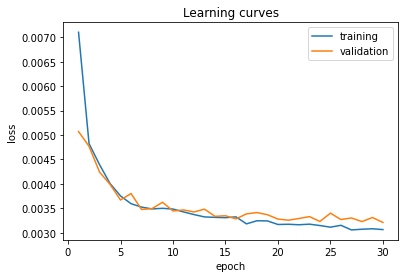

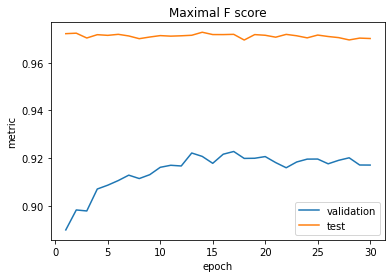

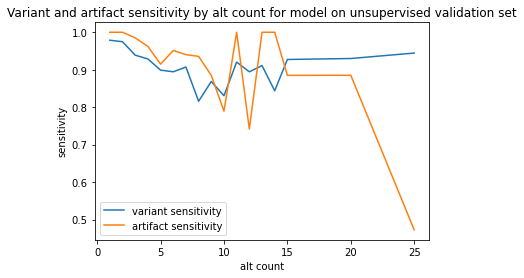

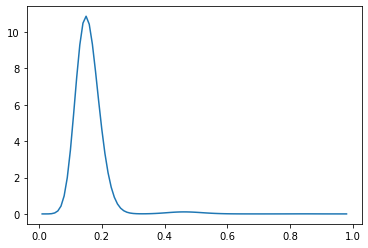

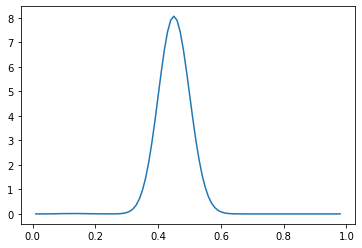

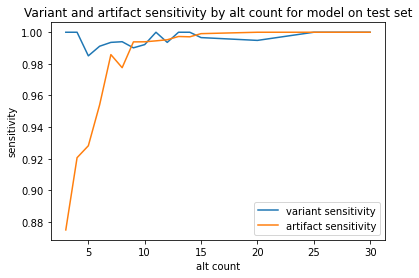

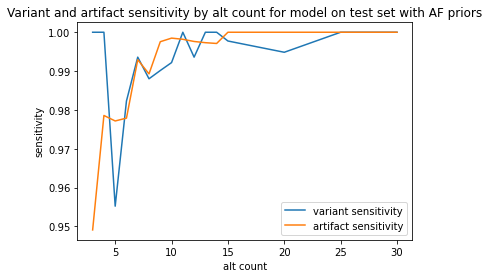

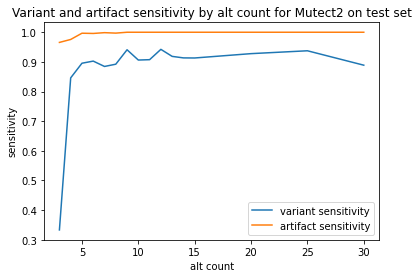

In [350]:
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 30)

Loading datasets from pickled files
tensor([ 60.,  30.,   1.,   0.,  24.,  21., 337.,  95.,  95.,   0.,   0.])
tensor([0.0876, 0.0000, 0.0000, 1.0000, 1.0000, 1.5000, 1.3333, 1.2500, 1.2000])
tensor([ 33.,  13.,   1.,   1.,  46.,  93., 243., 336., 335.,   1.,   2.])
tensor([0.4519, 0.1716, 9.0000, 0.4840, 3.0000, 1.5000, 1.0000, 1.0000, 0.8000])
tensor([ 60.,  30.,   1.,   0.,  24.,  57., 337.,  96.,  96.,   0.,   0.])
tensor([0.0778, 0.0261, 4.0000, 1.0000, 1.0000, 1.5000, 1.3333, 1.2500, 1.2000])
tensor([ 36.,  13.,   1.,   1.,  46.,  93., 245., 337., 337.,   1.,   5.])
tensor([ 0.3226,  0.1507, 24.0000,  0.5560,  3.0000,  1.5000,  1.0000,  1.0000,
         0.8000])
Dataset sizes -- training: 172216, validation: 19136, test: 17645
Training data includes 17 PASS variants labelled as artifacts.
Training data includes 168834 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
E

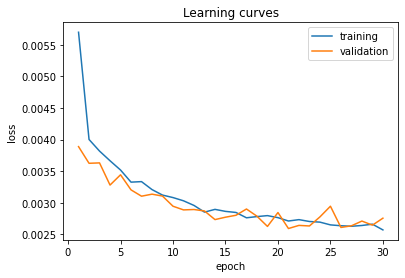

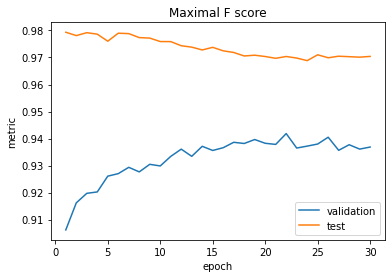

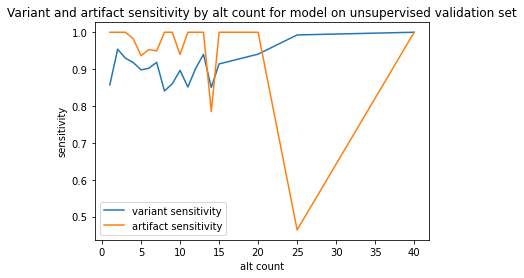

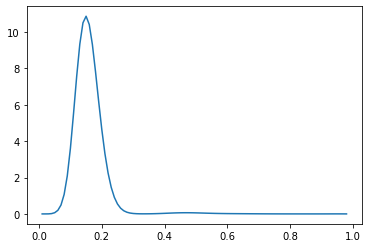

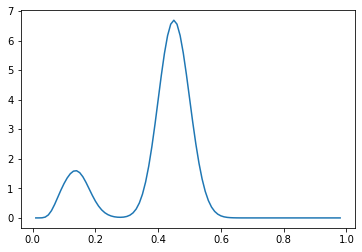

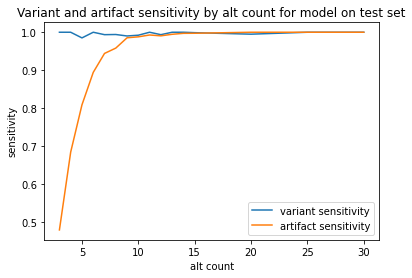

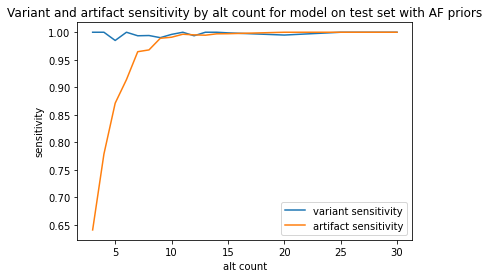

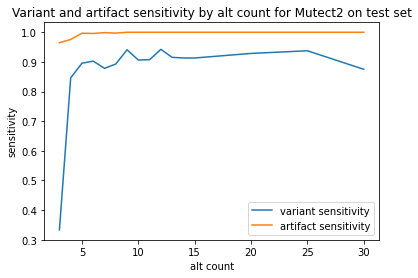

In [374]:
# scaling
run_evaluation([DREAM_1_PAIR], DREAM_1_TEST, 30)

Loading datasets from pickled files
Dataset sizes -- training: 203337, validation: 22593, test: 17645
Training data includes 20 PASS variants labelled as artifacts.
Training data includes 199332 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
M3 sensitivity and precision: 0.987673343605547, 0.9524517087667161
M2 sensitivity and precision: 0.9130970724191063, 0.966721044045677


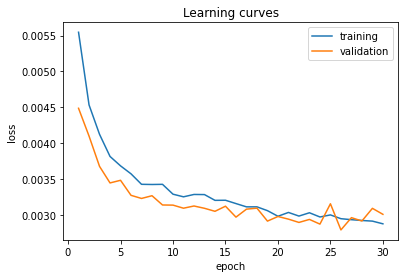

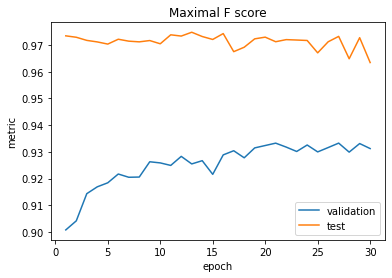

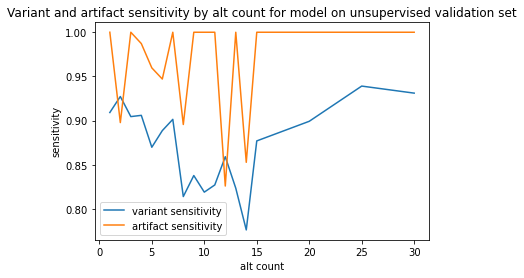

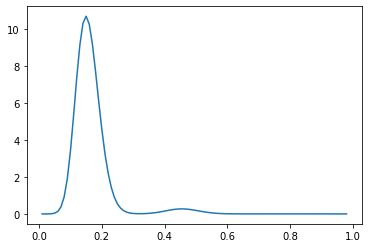

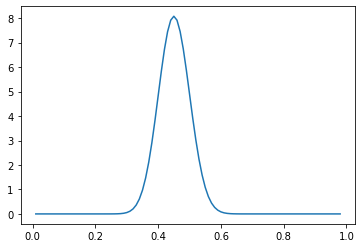

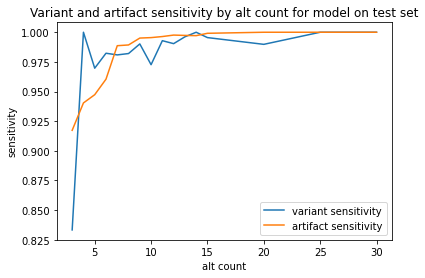

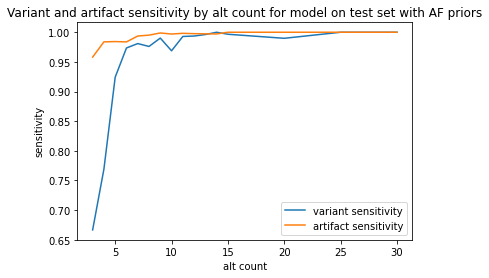

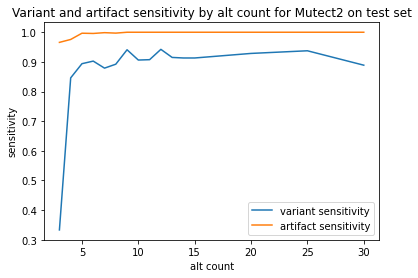

In [351]:
run_evaluation([DREAM_1_TUMOR], DREAM_1_TEST, 30)

Loading datasets from pickled files
Dataset sizes -- training: 157115, validation: 17458, test: 17645
Training data includes 29 PASS variants labelled as artifacts.
Training data includes 154029 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
M3 sensitivity and precision: 0.9910576626580326, 0.9571173317450864
M2 sensitivity and precision: 0.9130434782608695, 0.9663838120104439


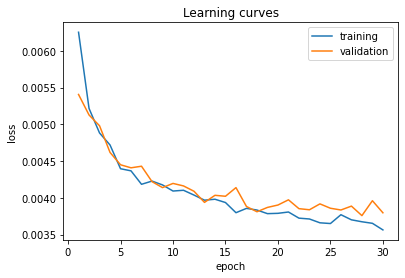

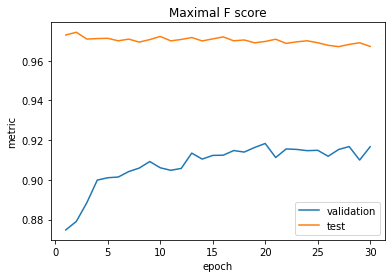

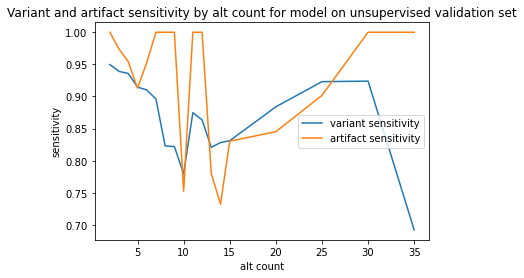

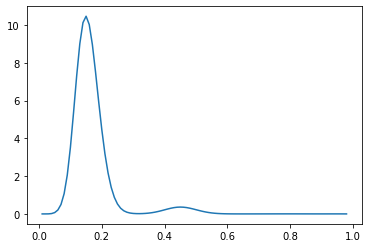

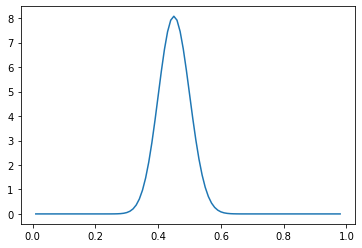

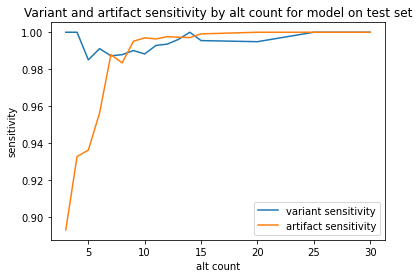

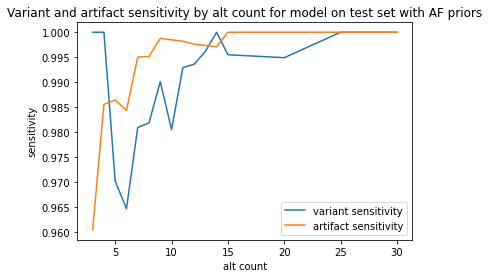

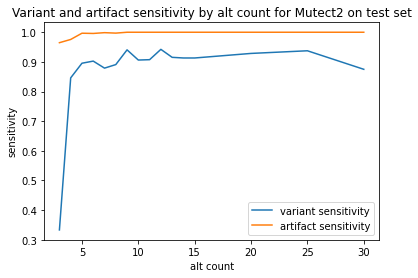

In [352]:
run_evaluation([DREAM_1_NORMAL], DREAM_1_TEST, 30)

Loading datasets from pickled files
Dataset sizes -- training: 126638, validation: 14071, test: 17645
Training data includes 24 PASS variants labelled as artifacts.
Training data includes 124163 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
M3 sensitivity and precision: 0.9944547134935305, 0.9430324276950044
M2 sensitivity and precision: 0.9131238447319778, 0.9664166938376263


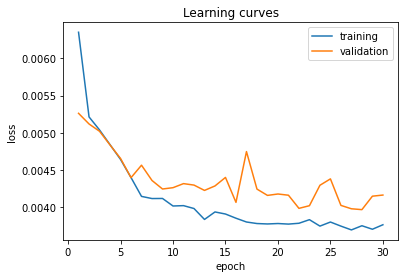

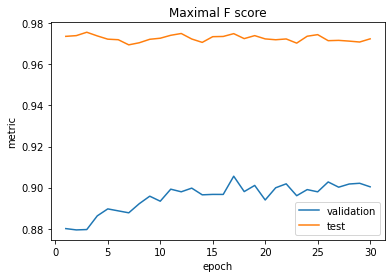

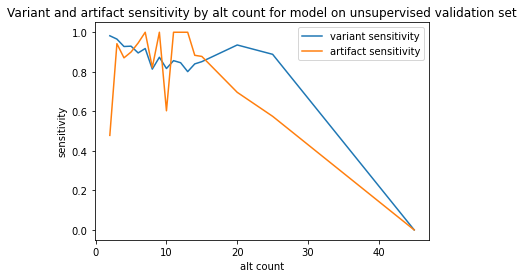

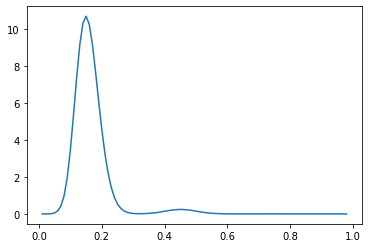

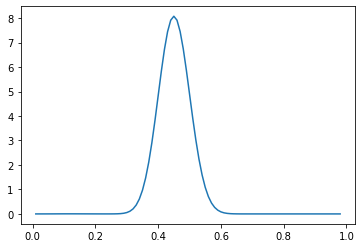

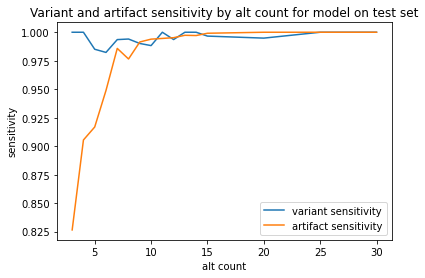

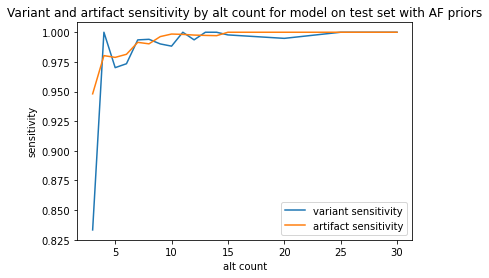

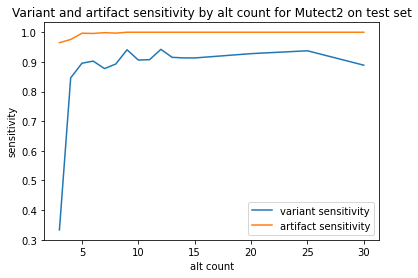

In [353]:
run_evaluation([DREAM_1_NORMAL_PAIR], DREAM_1_TEST, 30)

Loading datasets from pickled files
Dataset sizes -- training: 463333, validation: 51482, test: 17645
Training data includes 97 PASS variants labelled as artifacts.
Training data includes 454242 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
M3 sensitivity and precision: 0.9854938271604938, 0.9666969421737814
M2 sensitivity and precision: 0.912962962962963, 0.9663508657301535


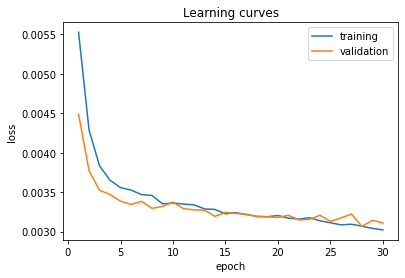

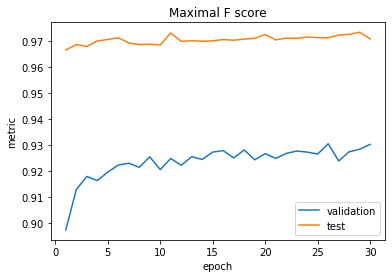

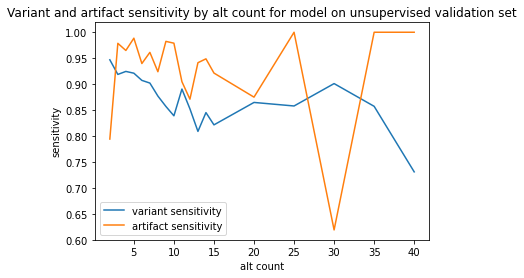

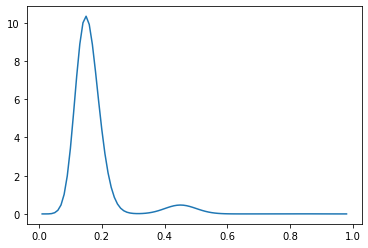

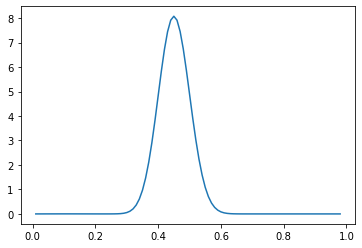

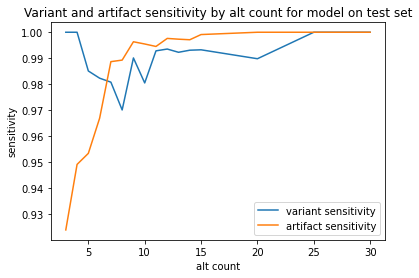

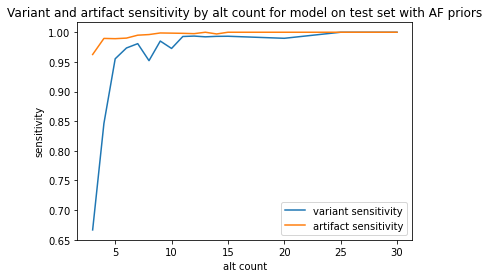

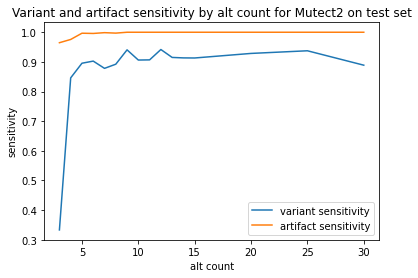

In [354]:
run_evaluation([DREAM_1_NORMAL, DREAM_2_NORMAL], DREAM_1_TEST, 30)

In [355]:
run_evaluation([DREAM_1_NORMAL, DREAM_2_NORMAL, DREAM_3_NORMAL, DREAM_4_NORMAL], DREAM_1_TEST, 30)

Loading datasets from pickled files


KeyboardInterrupt: 

Loading datasets from pickled files
Dataset sizes -- training: 253918, validation: 28214, test: 23427
Training data includes 52 PASS variants labelled as artifacts.
Training data includes 248936 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epo

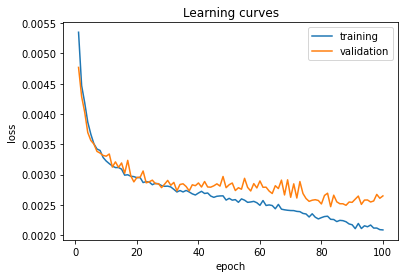

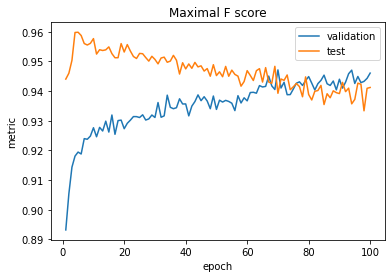

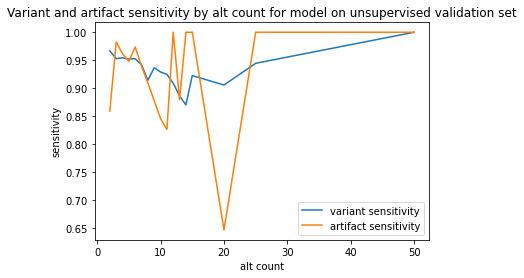

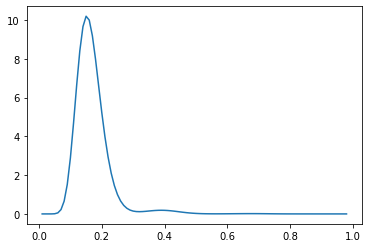

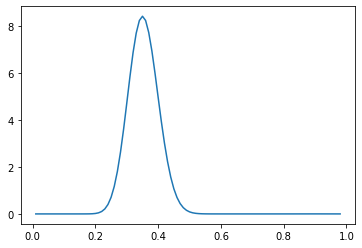

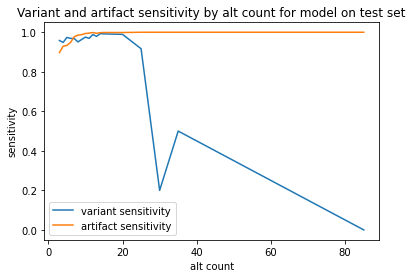

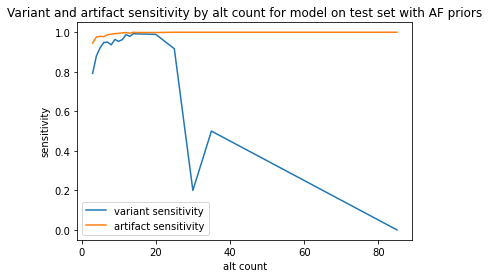

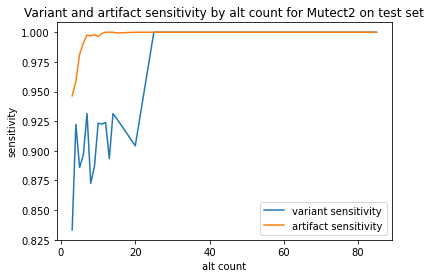

In [275]:
run_evaluation([DREAM_2_PAIR], DREAM_2_TEST, 100)

Loading datasets from pickled files
Dataset sizes -- training: 347738, validation: 38638, test: 43646
Training data includes 1943 PASS variants labelled as artifacts.
Training data includes 340921 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
E

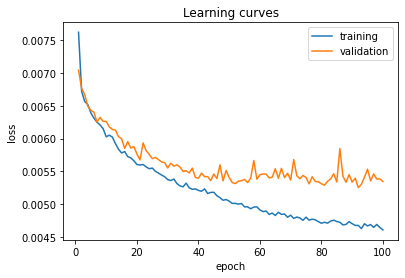

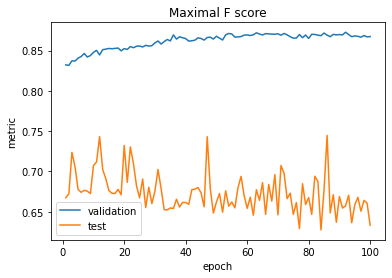

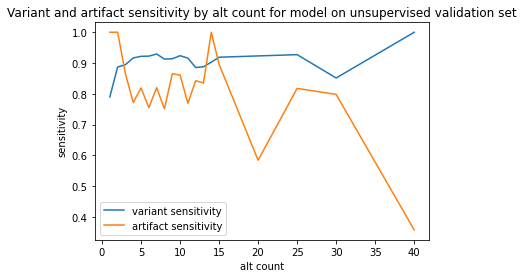

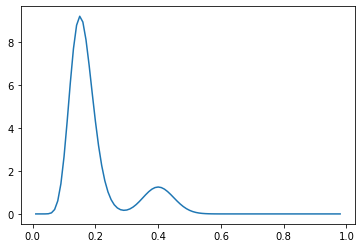

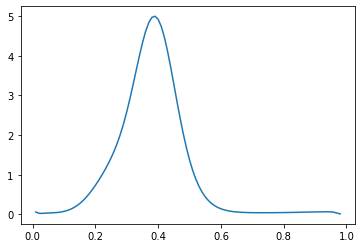

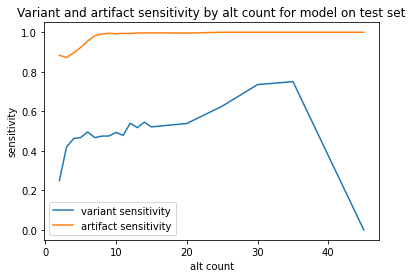

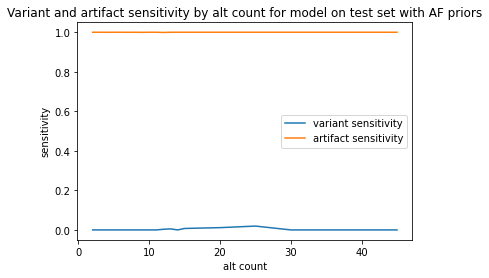

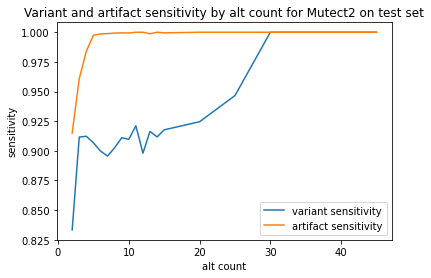

In [276]:
run_evaluation([DREAM_3_PAIR], DREAM_3_TEST, 100)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 43646
Training data includes 18 PASS variants labelled as artifacts.
Training data includes 168809 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epo

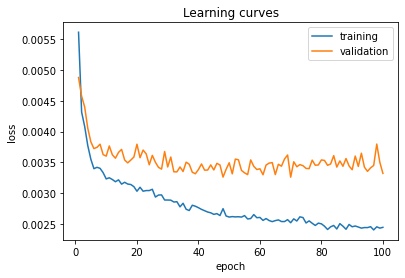

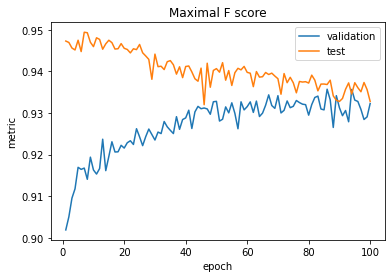

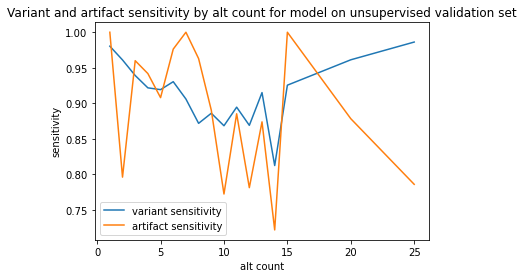

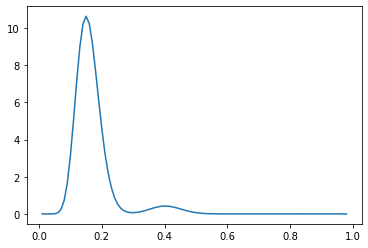

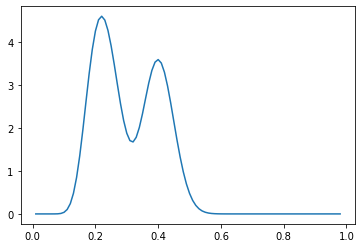

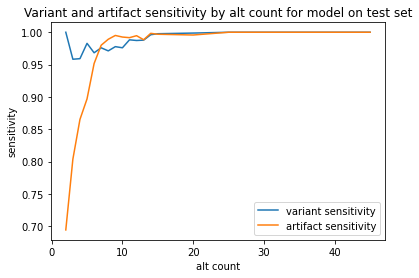

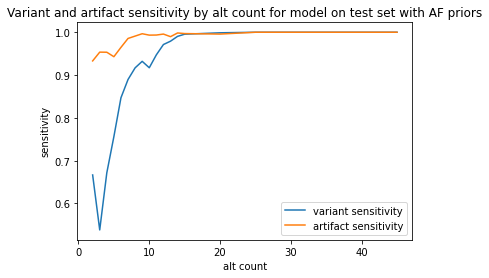

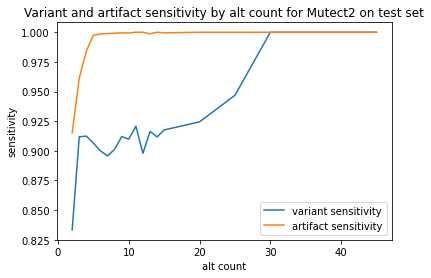

In [277]:
run_evaluation([DREAM_1_PAIR], DREAM_3_TEST, 100)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 25474
Training data includes 17 PASS variants labelled as artifacts.
Training data includes 168835 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epo

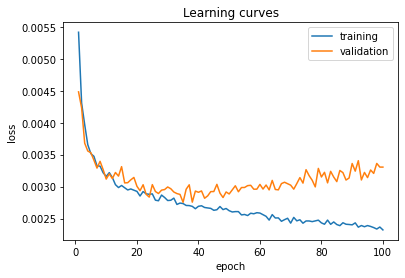

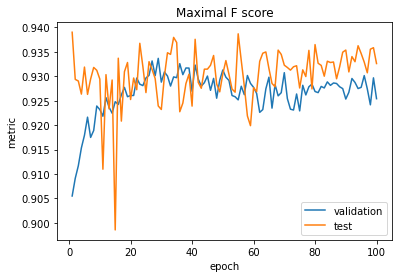

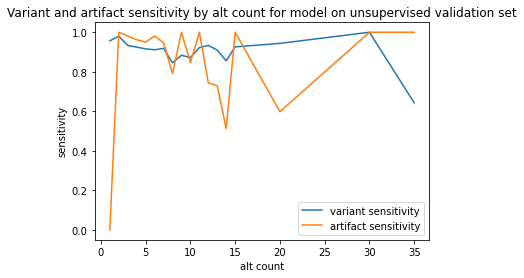

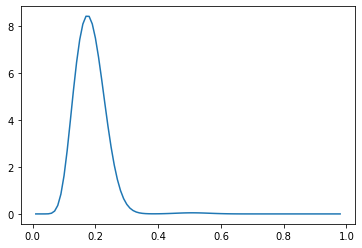

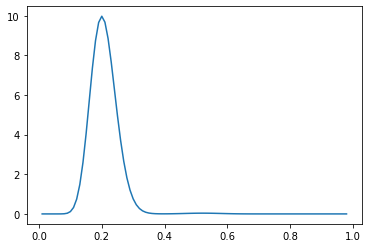

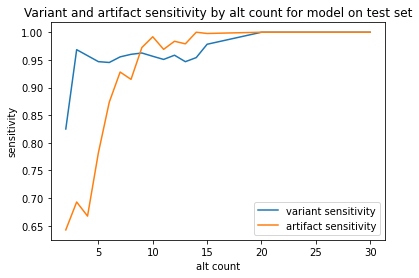

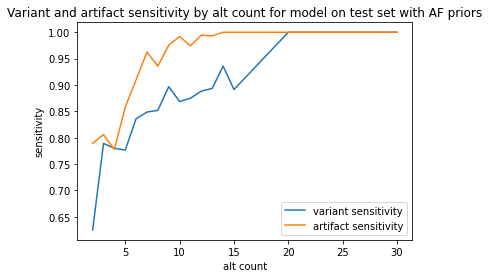

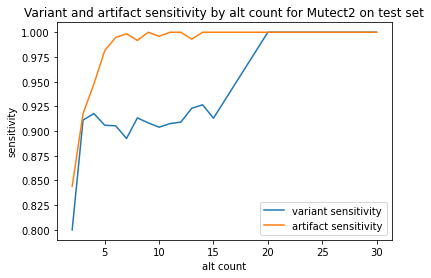

In [278]:
run_evaluation([DREAM_1_PAIR], DREAM_4_TEST, 100)

Loading datasets from pickled files
Dataset sizes -- training: 172216, validation: 19136, test: 23427
Training data includes 16 PASS variants labelled as artifacts.
Training data includes 168844 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epo

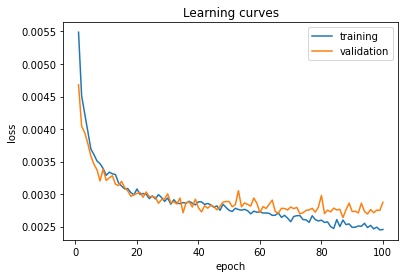

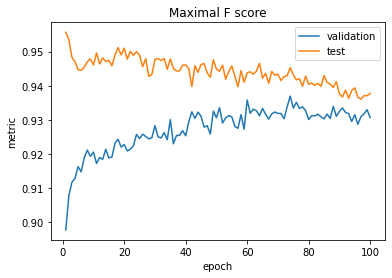

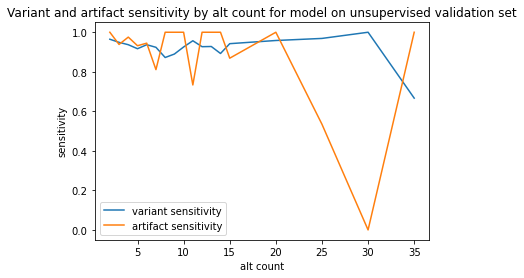

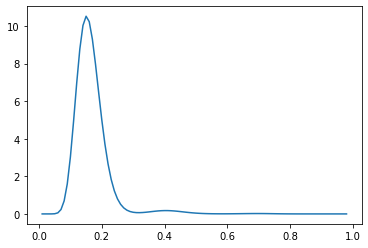

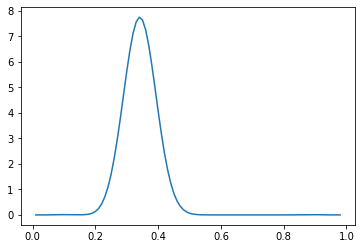

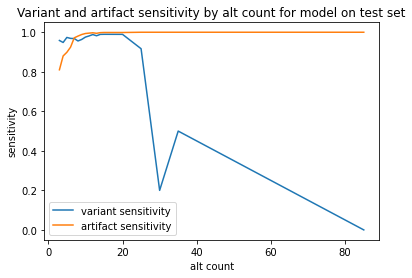

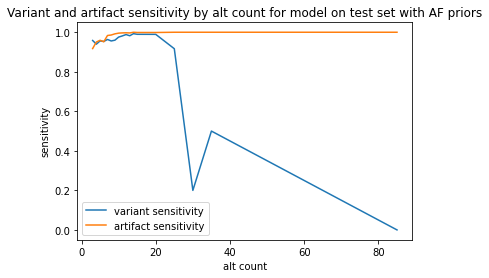

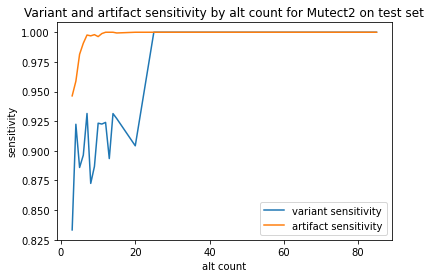

In [279]:
run_evaluation([DREAM_1_PAIR], DREAM_2_TEST, 100)

In [280]:
train, valid, test = make_datasets([DREAM_1_PAIR], DREAM_1_TEST)

Dataset sizes -- training: 172216, validation: 19136, test: 17645


In [330]:
train1, valid1, test1 = make_datasets([DREAM_1_NORMAL], DREAM_1_TEST)

Dataset sizes -- training: 3080, validation: 343, test: 17645


In [343]:
train2, valid2, test2 = make_datasets([DREAM_1_TUMOR], DREAM_1_TEST)

Dataset sizes -- training: 3987, validation: 443, test: 17645


In [344]:
[train2[n].artifact_label() for n in range(100)]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [304]:
n = 14
train[n].artifact_label(), train[n].mutect2_data().filters(), train[n].mutect2_data().tlod(), train[n].mutect2_data().tumor_depth()

(0,
 {'clustered_events', 'germline', 'haplotype', 'normal_artifact'},
 98.65,
 26)

In [305]:
artifacts = [dat for dat in train if dat.artifact_label() == 1]

In [306]:
len(artifacts)

3408

In [326]:
n = 19
artifacts[n].mutect2_data().filters(), artifacts[n].mutect2_data().tlod()

({'clustered_events', 'haplotype', 'normal_artifact', 'panel_of_normals'},
 15.71)

Loading datasets from pickled files
Dataset sizes -- training: 3080, validation: 343, test: 17645
Training data includes 28 PASS variants labelled as artifacts.
Training data includes 0 artifacts labelled as good variants.
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


ZeroDivisionError: division by zero

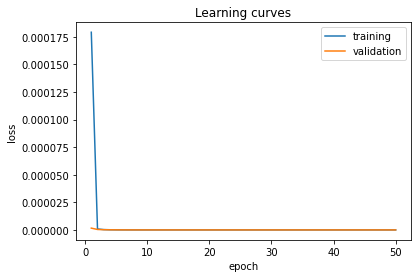

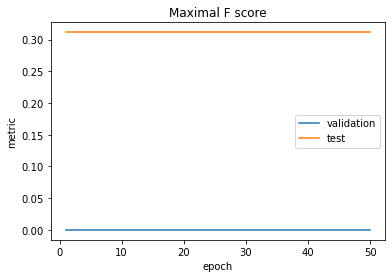

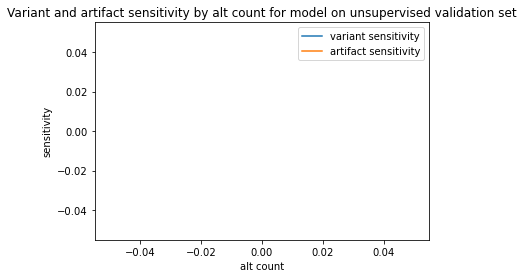

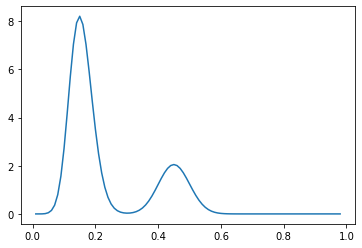

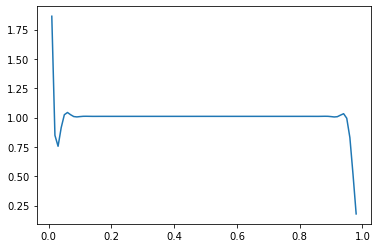

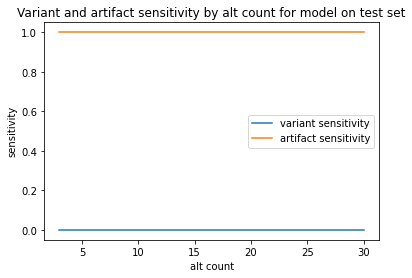

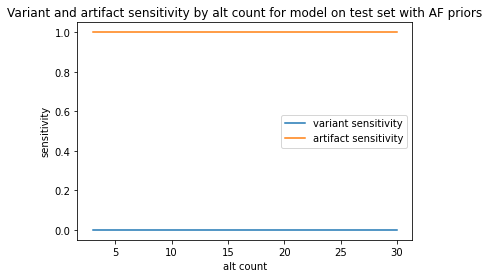

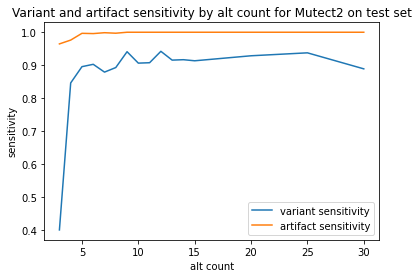

In [329]:
run_evaluation([DREAM_1_NORMAL], DREAM_1_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_NORMAL], DREAM_1_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_TUMOR], DREAM_1_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_NORMAL_PAIR], DREAM_1_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_PAIR, DREAM_2_PAIR], DREAM_1_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_NORMAL, DREAM_2_NORMAL, DREAM_3_NORMAL], DREAM_2_TEST, 50)

In [ ]:
run_evaluation([DREAM_1_NORMAL, DREAM_2_NORMAL, DREAM_3_NORMAL], DREAM_3_TEST, 50)